# Markov Decision Processes and Optimal Control


## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Modules](#Python-Modules)
* [Markov Decision Processes](#Markov-Decision-Processes)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

Goal of this notebook is to introduce _Markov Decision Processes_ (MDPs) and how to solve them by _dynamic programming_. 
MDPs model the interaction between an agent and the environment.  

In the full reinforcement learning problem the environment-agent model is unknown. However, an understanding of MDPs is fundamental for reinforcement learning.  

<!-- Reinforcement Learning [[SUT98]](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) and present an overview of the principles and background.-->

## Requirements

### Python Modules

With the deep.TEACHING convention, all python modules needed to run the notebook are loaded centrally at the beginning.

In [ ]:
# Python Standard Library
import os

# External Modules
import numpy as np
import matplotlib.pyplot as plt
#import mpl_toolkits.mplot3d

from scipy.stats import poisson

## Markov Decision Processes

Markov decision processes (MDP) are a model of the agent-enviroment interaction. 

In this notebook key elements of MDPs are introduced. 

### Definition
A countable MDP is defined as a triple $\mathcal M = (\mathcal{S, A, P_{0}}) $ with

* A countable not-empty set of states $s \in \mathcal S$.
* Countable not-empty set of actions $a \in \mathcal A$.
* Transition probability kernel $\mathcal P_0$: $\mathcal P_0$ describes the (stochastic) reaction of the enviroment to the agents action. For each state-action pair $(S=s, A=a) \in \mathcal S \times \mathcal A$ there is a probability distribution over $\mathcal S \times \mathbb R$: $P_0(\cdot \mid s, a)$ with the following semantics: 
For $U \in \mathcal S \times \mathbb R$ is $P_0(U \mid s, a)$ the probability that the next states and the reward $R$ belongs to the set $U$ given that the current state is $s$ and the action taken is $a$.  

MDPs are models of the interaction between the enviroment and the agent.

### Agent and Environment

An agent takes an action in the given environment with the goal to maximize the long-term received reward (cumulative reward). This principle can be seen in figure 1 as an infinite loop.
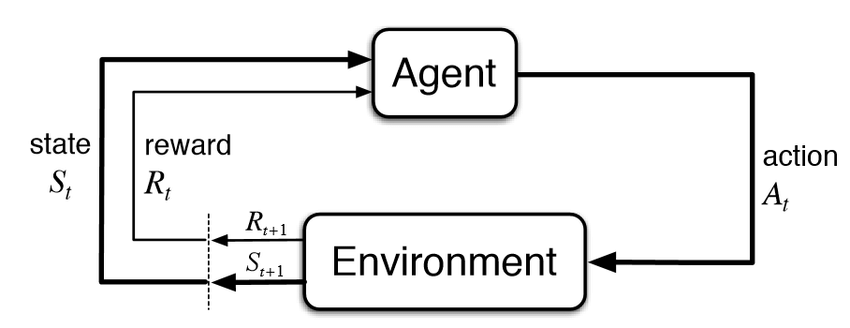
<center>Figure 1 - the agent–environment interaction in a Markov decision process <a href="https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf">[SUT98]</a></center>

At timestep $t$ the agent receives a state $S_{t}=s$ (for example a camera image) and performs an action $A_{t}=a$. In the next timestep $t+1$, a reward $R_{t+1}=r$ and the resulting new state $S_{t+1}=s'$ from the taken action $A_{t}=a$ of timestep $t$, is given to the agent. Notice, that the state and reward which are received in $t+1$ are a result of an action taken at timestep $t$, so the reward is not instantaneous but delayed.  


If the random variable $S_t$ takes value $s$ we use the abbreviation $s_t$. 

The MDP and agent together give rise to a sequence called *__trajectory__* that begins like this:
<p>
$$s_{0}, a_{0}, r_{1},s_{1}, a_{1}, r_{2}, s_{2}, a_{2}, r_{3}, \dots $$
<p>



### Reward Function

From the definition we also have a _reward function_ $\mathcal R(s,a)$ which is the expected reward for taking action $a$ in state $s$:

$$ \mathcal R(s,a) = \mathbb E [R \mid S = s, A =a]=\int_{\mathbb R} \sum_{\mathcal s' \in S} r \cdot P_0(s',r \mid s,a) dr $$

We will explicit represent the function as matrix, so we will use the notation $\mathcal R_s^a$.

Analog we also have a function (of three variables) if the next state $S_{t+1}=s'$ at time $t+1$ is also given:

$$ \mathcal R(s, a, s') = \mathcal R_{s,s'}^a =\mathbb E [R_{t+1} \mid S_t = s, A_t =a, S_{t+1}=s'] = \int_{\mathbb R} r \cdot P_0(s', r \mid s,a) dr $$



### Markov Property
A state $S_t=s$ includes all information about the past to predict future states. Additional information about the past such as previous states and actions doesn't give more information about future states.

In other word the states are Markovian, i.e.:

$$ \mathbb P[S_{t+1}, R_{t+1} \mid S_t, A_t] = \mathbb P[S_{t+1}, R_{t+1} \mid S_1, A_1 \dots , S_{t-1}, A_{t-1}, S_{t}, A_{t}] $$



### State transition probability kernel
From $\mathcal P_0$ we can derive the state transition probability kernel $\mathcal P$ which for any $(s, a, s') \in \mathcal S \times \mathcal A \times \mathcal S$ triple gives the probability of moving from state $s$ to some other state $s'$ provided that action $a$ was chosen in $s$:

$$ P(s,a,s') = P_0(\{s'\} \times \mathbb R \mid a, s) $$

## Example: Jacks Car Rental 
(from [[SUT98]](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf))

"Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited $\$10$ by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of $\$2$ per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables with mean $\lambda$. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight."

* if more cars should be moved from a location as available, then it will charged the full action but only the available cars are moved.
* cars can be rent and returned at each location at all nationwide locations.


* We call the first location `A` and the second location `B`

__We want to answer the following question:__
* What is the optimal transfer policy of cars between branches?

In [ ]:
REQUEST_RATE = (3., 4.)      
RETURN_RATE  = (3., 2.)

GAMMA = 0.9
RENTAL_INCOME = 10
TRANSFER_COST = 2
TRANSFER_MAX  = 5
MAX_CAPACITY  = 20

# location indicies
A = 0
B = 1

### States

__Question:__  
* What are the valid states of the Jacks car rental enviroment?

__Answer:__
* Number of cars in each location ready for rent (e.g. the tuple (3,5) means 3 cars in location A and 5 cars in location B).

### Probability to be in a state
The probability for the states can be represented as a vector. For Jacks Car Rental:

$$ p(\vec s) = \begin{pmatrix} p(S=s_0) \\ p(S=s_1) \\ p(S=s_2) \\ \dots \\ p(S=s_{21}) \\ p(S=s_{22}) \\ \dots \\ p(S=s_{440}) \end{pmatrix} \begin{matrix}(0,0) \\ (0,1) \\ (0,2)\\ \dots \\ (1,0) \\ (1,1) \\ \dots \\ (20,20) \end{matrix} $$

For the Jacks Car Rental problem it's sometimes easier to work with a state probability matrix:

$$ P(\hat S) = \begin{pmatrix} P(S=s_{0}) & P(S=s_{1})& \dots & P(S=s_{20}) \\ P(S=s_{21}) & P(S=s_{22}) & \dots & P(S=s_{41})\\ \vdots & \vdots & \ddots & \vdots\\ . & . & \dots & p(S=s_{440}) \end{pmatrix} $$

The indices of $P(\hat S)$ correspond directly to the probability of the number of cars at each location.  
Note that we can use `np.reshape` to switch between the different representations.

In [ ]:
state_ = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1])
state_[11, 15] = 1. # 11 cars at A and 15 cars at B
state_.shape

In [ ]:
# Print all content of state_
state_

In [ ]:
# TODO
state = state_.reshape(-1)
print(state.shape)
state_11_15 = state

We define a function to get the most probable location of a given state:

In [ ]:
def get_most_probable_location(state):
    i = state.argmax()
    return (i//(MAX_CAPACITY+1), i%(MAX_CAPACITY+1))

In [ ]:
get_most_probable_location(state)

We define a function to get the state vector for given $a$ and $b$, where $a$ is the amount of cars at $A$ and $b$ is the amount of cars at $B$.

In [ ]:
def get_state_vector(a, b):
    s = np.zeros((MAX_CAPACITY+1)**2)
    s[a*(MAX_CAPACITY+1)+b] = 1
    return s

In [ ]:
assert get_most_probable_location(get_state_vector(11,12)) == (11,12)

### Actions
Actions are the nightly movements of the cars. We encode them as a number between -5 to 5, e.g.

* Action +3: move three cars from A to B.
* Action -1: move one car from B to A.


In [ ]:
action_space = np.arange(-TRANSFER_MAX, TRANSFER_MAX+1)
print(action_space)  # cars moved  
print(np.arange(11)) # action indices

### State transition probability kernel for Jacks Car Rental
Definition
$$ \vec s' = P \vec s $$

with

* $\vec s$: probabilities for the states at time $t$
* $\vec s'$: probabilities for the states at time $t+1$
* $P = \mathcal P $: State Transition Probability Kernel

In the following we construct the (transpose of the) _state transition probability kernel_. First note that the kernel decomposes as

$$ P = P_{ret} P_{req} P_{move} $$

with

* $P_{move}$: The kernel for the nightly moves according to the actions.
* $P_{req}$: The kernel for the requests of cars.
* $P_{ret}$: The kernel for the returns of cars.

__Note:__ for $P_{req}$ and $P_{ret}$ we don't have actions.


Form of the Transition Matrix: 
 - for earch old state we have a column
 - for each new states we have a row

__Note:__  
Here we have 441 possible states (for the old and new ones). So the transition matrix has dimension (441, 441).
Each column of the transition matrix describes how a states is transformed.

### Request State Transition Probability Kernel
We define a function that calculates the transitions for one given location. Therefore, the Poisson probability mass function (PMF) is used. For further information about Poisson distribution in general, see e.g. [here](https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459?gi=3b06308122e5).

In [ ]:
# construct request transitions for one location:
# e.g. state_1 = ((0,*), (1,*), ... (20,*)) 
#     are only the probabilities for location 1

MAX_PMF = 30

def get_request_transitions_for_one_location(loc):
    """
    Construct transition matrix P_{to, from} for one location only for requests.
    The matrix has form (21, 21). 
    
    Parameters
    ----------
    loc : int
        Location: 0 or 1
    
    Returns
    -------
    numpy.ndarray
        request transition matrix

    """
    assert(loc==A or loc==B)
    # transition matrix P_{to, from} for one location only requests
    transition_matrix = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1])
    
    request_pmf = poisson.pmf(np.arange(MAX_PMF), REQUEST_RATE[loc])
    np.testing.assert_almost_equal(request_pmf[-1], 0., decimal=12)
    for i in range(MAX_CAPACITY+1):  
        for j in range(MAX_CAPACITY+1):  
            if j==0:
                transition_matrix[i,j] = request_pmf[i:].sum()
            elif j<=i:    
                transition_matrix[i,j] = request_pmf[i-j]             
    return transition_matrix.T

In [ ]:
P_request_A_one_loc = get_request_transitions_for_one_location(A)
# all colums should sum to one
np.testing.assert_allclose(P_request_A_one_loc.sum(axis=0), 1.)
P_request_A_one_loc.shape

If we have e.g. eight cars at location A, after the renting the requested cars we get the following distribution:

In [ ]:
plt.plot(np.arange(MAX_CAPACITY+1), P_request_A_one_loc[:,8], '*b')
plt.xticks(np.arange(0, 21, step=1))
plt.xlabel("number of cars")
plt.ylabel("probability");

In [ ]:
P_request_A_one_loc[:,0]

In [ ]:
P_request_A_one_loc[:,1]

In [ ]:
# for testing the one location transition matricies
s = np.zeros(MAX_CAPACITY+1)
s[3] = 1
a = np.dot(P_request_A_one_loc, s)
np.testing.assert_almost_equal(a.sum(), 1.)
a

Note that the defined matrix has shape 21x21. So the index considers only the location A. 
A full state is given by the pair "(location A, location B)". So we must extend the matrix to a 
"full" transition matrix 441x441.

We define a function to retrieve the "full" transition matrix A for a given location.


In [ ]:
def full_transition_matrix_A(transition_one_loc):
    block_size = MAX_CAPACITY+1 # for convenience
    transition_matrix = np.zeros([block_size**2, block_size**2])
    for i in range(block_size):
        transition_matrix[i:block_size**2: block_size,
                          i:block_size**2: block_size] = transition_one_loc
    return transition_matrix

In [ ]:
P_request_A = full_transition_matrix_A(P_request_A_one_loc)
P_request_A#.shape

In [ ]:
# should mix only states of A: 
np.testing.assert_almost_equal(np.dot(P_request_A, state_11_15).reshape(MAX_CAPACITY+1,-1).sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_request_A, state_11_15).reshape(MAX_CAPACITY+1,-1)[:,15].sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_request_A, state_11_15).reshape(MAX_CAPACITY+1,-1)[:12,15].sum(), 1.)

We define a function to retrieve the full transition matrix B for a given location. 
Note, that the positions of equal B locations in the full state vector a different a for location A.

Full state vector:
$$\begin{bmatrix}(0,0) \\ (0,1) \\ (0,2)\\ \dots \\ (1,0) \\ (1,1) \\ \dots \\ (20,20) \end{bmatrix} $$

e.g. 
- indices for location A=0: $0,1, \dots, 20$
- indices for location B=0: $0,21,42, \dots, 420$

In [ ]:
def full_transition_matrix_B(transition_one_loc):
    block_size = MAX_CAPACITY+1 # for convenience
    transition_matrix = np.zeros([block_size**2, block_size**2])
    for i in range(block_size):
        transition_matrix[i*block_size:(i*block_size)+block_size,
                          i*block_size:(i*block_size)+block_size] = transition_one_loc
    return transition_matrix

In [ ]:
P_request_B_one_loc = get_request_transitions_for_one_location(1)
P_request_B = full_transition_matrix_B(P_request_B_one_loc)

In [ ]:
# should mix only states of B: 
np.testing.assert_almost_equal(np.dot(P_request_B, state_11_15).reshape(MAX_CAPACITY+1,-1).sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_request_B, state_11_15).reshape(MAX_CAPACITY+1,-1)[11].sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_request_B, state_11_15).reshape(MAX_CAPACITY+1,-1)[11,:16].sum(), 1.)

In [ ]:
# with the two request matricies for each location we can construct the full request matrix
P_request = np.dot(P_request_A, P_request_B)

In [ ]:
# The order of application shouldn't matter, so the commutator should be zero:
np.testing.assert_allclose(np.dot(P_request_A, P_request_B), np.dot(P_request_B, P_request_A))

### Return State Transition Probability Kernel

Similar to the requests, we define the return state transition probability kernel.

In [ ]:
MAX_PMF = 30

def get_return_transition_matrix_one_location(loc):
    """
    Construct transition matrix P_{to, from} for one location only for returns
    
    Parameters
    ----------
    loc : int
        Location: 0 or 1
    
    Returns
    -------
    numpy.ndarray
        transition matrix

    """
    assert(loc==0 or loc==1)
    transition_matrix = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1])

    return_pmf = poisson.pmf(np.arange(MAX_PMF), RETURN_RATE[loc])
    np.testing.assert_almost_equal(return_pmf[-1], 0., decimal=12)
    for i in range(MAX_CAPACITY+1):  
        for j in range(MAX_CAPACITY+1):  
            if j==MAX_CAPACITY:
                transition_matrix[i,j] = return_pmf[j-i:].sum()
            elif j>=i and j<MAX_CAPACITY:    
                transition_matrix[i,j] = return_pmf[j-i]     
    return transition_matrix.T

P_return_A_one_loc = get_return_transition_matrix_one_location(0)
np.testing.assert_almost_equal(P_return_A_one_loc.sum(axis=0), 1.)

In [ ]:
P_return_A = full_transition_matrix_A(P_return_A_one_loc)

# should mix only states of A: 
np.testing.assert_almost_equal(np.dot(P_return_A, state_11_15).reshape(MAX_CAPACITY+1,-1).sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_return_A, state_11_15).reshape(MAX_CAPACITY+1,-1)[:,15].sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_return_A, state_11_15).reshape(MAX_CAPACITY+1,-1)[11:,15].sum(), 1.)

In [ ]:
s = np.zeros(MAX_CAPACITY+1)
s[17] = 1
a = np.dot(P_return_A_one_loc, s)
st = np.dot(P_return_A , get_state_vector(17, 5))
np.testing.assert_almost_equal(a,st.reshape(MAX_CAPACITY+1,-1)[:,5])

In [ ]:
P_return_B_one_loc = get_return_transition_matrix_one_location(B)

In [ ]:
P_return_B = full_transition_matrix_B(P_return_B_one_loc)

# should mix only states of B: 
np.testing.assert_almost_equal(np.dot(P_return_B, state_11_15).reshape(MAX_CAPACITY+1,-1).sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_return_B, state_11_15).reshape(MAX_CAPACITY+1,-1)[11].sum(), 1.)
np.testing.assert_almost_equal(np.dot(P_return_B, state_11_15).reshape(MAX_CAPACITY+1,-1)[11,15:].sum(), 1.)

In [ ]:
P_return = np.dot(P_return_B, P_return_A)

np.testing.assert_allclose(np.dot(P_return_B, P_return_A), np.dot(P_return_A, P_return_B))

The combinations of requests and returns is given by the dot product:

$$ P_{ret/req} = P_{ret} P_{req} $$

In [ ]:
P_return_request = np.dot(P_return, P_request)

### Nightly Moves State Transition Probability Kernel
We implement $P_{move}$ as a 3d numpy array with indices [to_state_index, from_state_index, action_index].

In [ ]:
def get_moves(a, b, action):
    if action > 0: # from A to B
        return min(a, action)
    else:
        return max(-b, action)

def get_nightly_moves():
    transition_matrix = np.zeros([(MAX_CAPACITY+1)**2, (MAX_CAPACITY+1)**2, action_space.shape[0]])
    for a in range(MAX_CAPACITY+1):
        for b in range(MAX_CAPACITY+1):
            for i, action in enumerate(action_space):
                old_state_index = a*(MAX_CAPACITY+1)+b
                moves = get_moves(a, b, action)
                new_a = min(a - moves, MAX_CAPACITY)
                new_b = min(b + moves, MAX_CAPACITY)
                new_state_index = new_a *(MAX_CAPACITY+1) + new_b
                transition_matrix[new_state_index, old_state_index, i] = 1.
    return transition_matrix

**Note:**  
actions and indices for actions differ, e.g. action 2 has index 2+5.

In [ ]:
P_move = get_nightly_moves()

np.testing.assert_allclose(P_move.sum(axis=0), 1.)

# check some moves
# assert P_move[:,21*car_at_A+cars_at_B,action+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[new_cars_at_A, new_cars_at_B] == 1.
assert P_move[:,0,0].reshape(MAX_CAPACITY+1, -1)[0,0] == 1.

# e.g. from state [1,0] and action 1 => new state should be  [0,1]
assert P_move[:,21*1+0,1+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[0,1] == 1. 

assert P_move[:,21*1+1,-2+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[2,0] == 1. 
assert P_move[:,21*9+5,0+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[9,5] == 1. 
assert P_move[:,21*9+5,3+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[6,8] == 1. 
assert P_move[:,21*9+5,-3+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[12,2] == 1.
assert P_move[:,21*20+20,5+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[15,20] == 1. 
assert P_move[:,21*20+20,-4+TRANSFER_MAX].reshape(MAX_CAPACITY+1, -1)[20,16] == 1. 

In [ ]:
P_move.shape

Construct the full transition probability kernel (request, returns and nightly shifts):

In [ ]:
# this is the transpose of the state transition probability kernel
P = np.ndarray(((MAX_CAPACITY+1)**2, (MAX_CAPACITY+1)**2, action_space.shape[0]))
for i in range(action_space.shape[0]): # TODO: without a loop?
    P[:,:,i] = np.dot(P_return_request, P_move[:,:,i]) 

In [ ]:
P.shape

$P$ is the full state transition probability kernel for the Jack's car rental problem.

$P$ has the following indices: $(s', s, a)$

In [ ]:
np.testing.assert_almost_equal(P.sum(axis=0), 1.)

In [ ]:
for s_a in range(21):
    for s_b in range(21):
        for a in range(11):
            s_ = np.dot(P[:,:,a], get_state_vector(s_a, s_b))
            np.testing.assert_almost_equal(s_.sum(), 1.0)

In [ ]:
np.testing.assert_almost_equal(P.sum(axis=0), 1.)

In [ ]:
def plot3d_over_states(f, zlabel="", ):
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
    
    ax.set_xticks(np.arange(0,21,1))
    ax.set_yticks(np.arange(0,21,1))
    #plt.xticks(np.arange(0,1,21))
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

In [ ]:
# do action 3 in cars_at_loc (10,5), i.e move three car from A to B:
s_ = np.dot(P[:,:,3+TRANSFER_MAX], get_state_vector(10, 5))
plot3d_over_states(s_, 'probability')

In [ ]:
s_ = state_11_15
for i in range (500):
    s_ = np.dot(P[:,:, 1 + TRANSFER_MAX], s_)
    
print (get_most_probable_location(s_))

### Reward Function
Let's construct the expected reward aka reward function

$$ \mathcal R(s,a) = \mathcal R_s^a = \mathbb E[R \mid s, a] $$

In [ ]:
def get_reward():
    
    poisson_mask = np.zeros((2, MAX_CAPACITY+1, MAX_CAPACITY+1))
    po = (poisson.pmf(np.arange(MAX_CAPACITY+1), REQUEST_RATE[A]),
          poisson.pmf(np.arange(MAX_CAPACITY+1), REQUEST_RATE[B]))
    for loc in (A,B):
        for i in range(MAX_CAPACITY+1):
            poisson_mask[loc, i, :i] = po[loc][:i]
            poisson_mask[loc, i, i] = po[loc][i:].sum()
    # the poisson mask contains the probability distribution for renting x cars (x column) 
    # in each row j, with j the number of cars available at the location

    reward = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1, 2*TRANSFER_MAX+1])
    for a in range(MAX_CAPACITY+1):
        for b in range(MAX_CAPACITY+1):
            for action in range(-TRANSFER_MAX, TRANSFER_MAX+1):
                moved_cars = min(action, a) if action>=0 else max(action, -b)
                a_ = a - moved_cars
                a_ = min(MAX_CAPACITY, max(0, a_))
                b_ = b + moved_cars
                b_ = min(MAX_CAPACITY, max(0, b_))
                reward_a = np.dot(poisson_mask[A, a_], np.arange(MAX_CAPACITY+1)) 
                reward_b = np.dot(poisson_mask[B, b_], np.arange(MAX_CAPACITY+1))     
                reward[a, b, action+TRANSFER_MAX] = ( 
                            (reward_a + reward_b) * RENTAL_INCOME -
                            np.abs(action) * TRANSFER_COST )
                #if a==20 and b==20 and action==0:
                #    print (a_,b_, action)
                #    print (reward_a, reward_b)
                #    print (reward[a, b, action+TRANSFER_MAX])
        
    return reward

In [ ]:
Reward = get_reward()

In [ ]:
Reward = Reward.reshape(441,11)

### Policy
A policy $\pi$ is the behaviour of an agent. It maps states $s$ to actions $a$:

* Deterministic Policies: $a = \pi(s)$
* Stochastic Policies: $\pi(a\mid s) = P(a\mid s)$

### Markov Reward Process
A stationary policy $\pi$ and a MDP induce a MRP. Choose always the action $a$ according to the policy $\pi$.

A Markov Reward Process (MRP) is a tuple $\langle \mathcal{S}, \mathcal P_0'\rangle$ with

* $\mathcal S$: finite set of states $s$
* $\mathcal P'_0$: state transition Kernel matrix: $\mathcal P'_0$ assigns to each state $(S=s) \in \mathcal S$ a probability measure over $\mathcal S \times \mathbb R$: $P'_0(\cdot \mid s)$ with the following semantics: For $U \in \mathcal S \times \mathbb R$ is $P'_0(U \mid s)$ the probability that the next states and the reward $R$ belongs to the set $U$ given that the current state is $s$.

This implies again a reward function $\mathcal R^\pi(s)$ resp. $\mathcal R^\pi_s$ as for the MDP.

#### State Transition Probability Matrix for the MRP
$$ \mathcal P_{ss'}^\pi = \mathbb P [S_{t+1} = s' \mid S_t = s , a = \pi(s)] $$

$$ \mathcal P^\pi = \begin{pmatrix} \mathcal P_{11} & \dots & \mathcal P_{1n} \\ \vdots & & \\ \mathcal P_{n1} & \dots & \mathcal P_{nn} \end{pmatrix}$$

Note that the indicies of the matrix are $ss'$ in contrast to the above constructed state transition kernel which has the indicies $s'sa$.

Given a MDP $\langle \mathcal{S, A, \mathcal P_o} \rangle$ and a policy $\pi$:
* The state sequence $s_1, s_2, \dots $ is a Markov process
* The state and reward sequence $s_1, r_2, s_2, \dots $ is a Markov Reward Process where
* $\mathcal P^\pi_{s,s'} = \sum_{a\in \mathcal A} \pi(a \mid s) \mathcal P^a_{s,s'}$
* $\mathcal R^\pi_{s} = \sum_{a\in \mathcal A} \pi(a \mid s) \mathcal R^a_{s}$

In [ ]:
# choose in each state action 2 (move two cars from A to B)
policy = np.ones((MAX_CAPACITY+1)**2, dtype=int) * 2
policy.shape

In [ ]:
def get_transition_kernel_for_policy(policy):
    # use advanced indexing to get the entiers 
    return P[:, range((MAX_CAPACITY+1)**2), policy+TRANSFER_MAX]

In [ ]:
P_pi = get_transition_kernel_for_policy(policy)
np.testing.assert_allclose(P_pi.sum(axis=0), 1.) 

In [ ]:
Reward.shape

In [ ]:
def get_P_reward_for_policy(policy):
    P_pi = get_transition_kernel_for_policy(policy)
    return P_pi, Reward[range((MAX_CAPACITY+1)**2), policy+TRANSFER_MAX]

In [ ]:
get_P_reward_for_policy(policy)[1].shape

In [ ]:
policy = np.ones((MAX_CAPACITY+1)**2, dtype=int) * 5
P_pi, reward = get_P_reward_for_policy(policy)

In [ ]:
plot3d_over_states(reward, 'avg reward')

### Total Discounted Reward
The _return_ $G_t$ is defined as the total discounted reward:

$$ G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots = \sum_{k=0}^\infty \gamma^k R_{t+k+1} $$

#### Sum of discounted rewards is finite
Note that with all rewards $R_t>0$

$$ \sum_{t=0}^\infty R_t = \infty $$

Independent of the actual values of $R_t$. So we can't compare the (expected) reward of different states respectivly policies (which cases the state sequence).

But $$ \sum_{t=0}^\infty \gamma^t R_t $$

with the discount $\gamma$

$0<\gamma<1$

has as result a finite number, because with the maximum reward $R_{max} = \max_t (R_t)$ in the serie it is bounded by 

$$ \sum_{t=0}^\infty \gamma^t R_t \leq \sum_{t=0}^\infty \gamma^t R_{max} = \frac{R_{max}}{1-\gamma} $$

#### Proof of $\sum_i \gamma^i = 1/(1-\gamma)$

$$ x = \gamma^0 +\gamma^1 + \gamma^2 + \dots $$

$$ \gamma^0 +\gamma^1 + \gamma^2 + \dots = \gamma^0 + \gamma (\gamma^0 +\gamma^1 + \gamma^2 + \dots) $$

$$ x = \gamma^0 + \gamma x = 1 + \gamma x $$

$$ x(1-\gamma) = 1 $$

$$ x = \frac{1}{1-\gamma} $$

### Value functions
The **state-value function** $v_\pi (s)$ of an MDP is the expected return starting from state $s$, and then follow policy $\pi$

$$ v_\pi (s) = \mathbb E_\pi[G_t \mid S_t=s] = \mathbb E \left[ \sum_{t'=t}^\infty \gamma^{t'-t} R_{t'+1} \mid S_t=s \right], s \in \mathcal S $$

The value function can be decomposed into an immediate part and the discounted value function of the successor states:

$$ v_\pi(s) = \mathbb E[G_t \mid S_t =s] \\ = \mathbb E [R_{t+1}+γR_{t+2}+\gamma^2 R_{t+3} + \dots \mid S_t =s] \\ = \mathbb E [R_{t+1} + \gamma (R_{t+2}+\gamma R_{t+3} + \dots ) \mid S_t = s] \\ = \mathbb E [R_{t+1} + \gamma G_{t+1} \mid S_t = s] \\ = \mathbb E [ R_{t+1} \mid S_t = s]+ \gamma v_\pi(S_{t+1} ) $$

so, we have the __Bellmann Equation__ (for deterministic policies): 

$$ v_\pi(s) = \mathcal R_s^\pi + \gamma \sum_{s'\in \mathcal S} P_{ss'}^\pi v_\pi (s') $$

Note: $v(s')$ are the values of the successor states of $s$, so in $\sum_{s'\in \mathcal S} P_{ss'} v(s')$ the weights $P_{ss'}$ of the values $v(s')$ are the transitions back in time.

#### Bellman Equation
also for non deterministic policies:

$$ v_\pi(s) = \sum_a \pi(a \mid s) \left( \mathcal R_s^a + \gamma \sum_{s' \in \mathcal S} \mathcal P^a_{s,s'} v_\pi(s')\right) $$

Bellmann equations in vector-matrix form: 

$$ \vec v = \mathcal R^{\pi} + \gamma P^{\pi} \vec v $$

Here, we can directly solve the Bellmann equation: 

$$ \vec v = (I - \gamma \mathcal P^\pi)^{-1} \mathcal R^\pi $$

In [ ]:
def evaluate_policy(policy):
    P_pi_transpose, reward = get_P_reward_for_policy(policy)
    
    ### Here we must use P_pi_transpose.T - transformation back in time to the previous state!
    values = np.dot(np.linalg.inv(np.eye((MAX_CAPACITY+1)**2) - GAMMA * P_pi_transpose.T), reward)
    return values

In [ ]:
policy_ = np.zeros(((MAX_CAPACITY+1)**2), dtype=int)
values = evaluate_policy(policy_)
plot3d_over_states(values, 'v')

For large state spaces computing the inverse is costly in terms of space and time. However, the bellman
equation can be solved by an iteration:

### Policy Evaluation
Computing the state-value function $v^\pi(s)$ for an arbitrary policy by an **iterative** application of Bellman expectation backup is called policy evaluation:

* $v_1 \rightarrow v_2 \rightarrow v_3 \rightarrow \dots \rightarrow v_\pi$
* loop until convergence (using *synchronous* backups)
  * at each iteration $k+1$
  * for all states $s \in \mathcal S$
  * update $v_{k+1}(s)$ from $v_k(s')$, where $s'$ is a successor state of $s$

$$ \vec v_{k+1} = \vec {\mathcal R}^\pi + \gamma {\mathcal P}^\pi \vec v_{k} $$

In [ ]:
def evaluate_policy_by_iteration(policy, values = np.zeros((MAX_CAPACITY+1)**2)):
    P_pi, reward = get_P_reward_for_policy(policy)
    converged = False
    while not converged:
        new_values = reward + GAMMA * np.dot (P_pi.T, values)
        if np.allclose(new_values, values, rtol=1e-07, atol=1e-10):
            converged = True
        values = new_values
    return values

In [ ]:
values_ = evaluate_policy_by_iteration(policy_)

In [ ]:
np.testing.assert_almost_equal(values, values_, decimal=3)

### Optimal Value Function

$$ v^* (s) = \max_\pi v_\pi(s) $$

The optimal value $v^*(s)$ of state $s \in \mathcal S$ is defined as the highest achievable expected return when the process is started from state $s$. The function $v^* : \mathcal S \rightarrow \mathbb R$ is called the *optimal value function*.

### Policy Iteration
* Starting with an arbitrary policy
* Iteration until the values converge (to the optimal policy). Alternating sequence of
  * _Policy Evaluation_ : Compute the values of the policy
  * _Greedy Policy Improvement_: Use the "best" action in each state, i.e. chose the action which result in the highest return for each state. 


["Policy iteration often converges in surprisingly few iterations."](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node43.html) [SUT98]

#### Greedy Policy Improvement

For _greedy policy improvement_ we need the model (transition probabilities) if we are using the value function $v(s)$: For each action $a$ we compute the probabilities of the next states and calculate the average value of the discounted return.

 
If we start from state $s$ with action $a$, and then follow policy $\pi$ we get as expected return 

$$ q_\pi (s,a) = \mathbb E \left[ R\mid s,a \right]+ \mathbb E \left[ \gamma \sum_{s'\in \mathcal S} P_{ss'}^\pi v_\pi (s') \right]
$$

$q_\pi (s,a)$ is called the _action-value function_ $q_\pi (s,a)$.

Here, we compute $q$ explicitly for each state $s$ and action $a$ (respectivly in matrix form). For each state we chose the action that results in the highest value.  

To understand why _Greedy Policy Improvement_ works read the section of Sutton's book about the [policy improvement](http://incompleteideas.net/book/first/ebook/node42.html).

In [ ]:
def greedy_improve(values, P=P):
    P_ = P.transpose(1, 0, 2) # we used the model for improvement
    all_pure_states = np.eye((MAX_CAPACITY+1)**2)
    new_states = np.dot(all_pure_states, P_) 
    q = np.dot(new_states.transpose(2,1,0), values) 
    q = q.T + Reward
    policy_indices = np.argmax(q, axis=1)
    policy = policy_indices - TRANSFER_MAX
    return policy

In [ ]:
def improve_policy(policy):
    values = evaluate_policy_by_iteration(policy)
    not_converged = True
    while not_converged:
        print (values.mean())
        new_policy = greedy_improve(values)
        #new_values = evaluate_policy(new_policy)
        new_values = evaluate_policy_by_iteration(new_policy, values)
        if np.allclose(new_values, values, rtol=1e-02):
            not_converged = False
        values = new_values 
    return new_policy

In [ ]:
def plot_policy(policy):
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")

In [ ]:
policy = improve_policy(policy)

In [ ]:
values_ = evaluate_policy_by_iteration(policy)
plot3d_over_states(values_, 'v') 

In [ ]:
plot_policy(policy)

## Q-Function

The **action-value function** $q_\pi (s,a)$ of an MDP is the expected return starting from state $s$ with action $a$, and then follow policy $\pi$

$$ q^\pi (s,a) = \mathbb E_\pi[G_t \mid S_t=s, A_t=a] $$

### Optimal action-value function

$$ q^* (s, a) = \max_\pi q^\pi(s, a) $$

The optimal action-value $q^*(s, a)$ of state-action pair $(s,a) \in \mathcal S \times \mathcal A$ gives the highest achievable expected return when the process is started from state $s$, and the first action chosen is $a$. The function $q^* : \mathcal S \times \mathcal A \rightarrow \mathbb R$ is called the optimal action-value function.

### Connection between optimal value- and action-value function

$$ v^*(s) = \max_{a \in \mathcal A} q^*(s,a), s \in \mathcal S $$

$$ q^*(s,a) = \mathcal R_s^a + \gamma\sum_{s' \in \mathcal S} P(s,a,s')v^*(s') ; s \in \mathcal S, a \in \mathcal A $$

### Bellman Equation for Q

$$ q_\pi(s, a) = \mathcal R_s^a + \gamma \sum_{s' \in \mathcal S} \mathcal P^a_{s,s'} \left( \sum_{a'\in \mathcal A} \pi(a' \mid s') q_\pi(s',a') \right) $$

for a deterministic policy: 

$$ q_\pi(s, a) = \mathcal R_s^a + \gamma \sum_{s' \in \mathcal S} \mathcal P^a_{s,s'} q_\pi(s',\pi(s')) $$

$$ \hat Q^\pi = \hat R + \gamma \mathcal P \vec Q^\pi_\pi $$

with

* $\vec \pi$: Policy vector
* Matricies $\hat Q^\pi, \hat R$ with entries $\cdot_{sa}$
* 3d Array $\mathcal P$ with entries $\cdot_{sas'}$
* $\vec Q^\pi_\pi = \vec v^\pi$

### Policy Evaluation for Q

Computing the state-action-value function $q^\pi(s, a)$ for an arbitrary policy by an **iterative** application of Bellman expectation backup is also called policy evaluation:

* $q_1 \rightarrow q_2 \rightarrow q_3 \rightarrow \dots \rightarrow q_\pi$
* using synchronous backups
  * at each iteration $k+1$
  * for all states $s \in \mathcal S$ and $a \in \mathcal A$
  * update $q_{k+1}(s, a)$ from $q_k(s', \cdot)$, where $s'$ is a successor state of $s$.

$$ \hat Q^{k+1} = \hat R + \gamma \mathcal P \vec Q^k_{k} $$

In [ ]:
# Iterative update of the bellmann equation for Q
def evaluate_policy_Q_by_iteration(policy, Q = np.zeros([(MAX_CAPACITY+1)**2, 2*TRANSFER_MAX+1])):
    converged = False
    P_ = P.transpose(1,2,0)
    while not converged:
        policy_index = policy + TRANSFER_MAX
        Q_pi = Q[np.arange((MAX_CAPACITY+1)**2), policy_index]
        new_Q = Reward + GAMMA * np.dot(P_, Q_pi)
        if np.allclose(new_Q, Q):
            converged = True
        Q = new_Q
    return Q    


### Policy Iteration for Q
* Starting with an arbitrary policy
* Iteration until the values converge (to the optimal policy). Alternating sequence of
  * Policy Evaluation : Compute the values of the policy
  * Greedy Policy Improvement:
    * $\pi'(s) = \text{arg} \max_{a \in \mathcal A} q^\pi(s,a)$
    * Note: Here we don't use the (transition) model.

In [ ]:
def greedy_improve_Q(Q):
    return np.argmax(Q, axis=1) - TRANSFER_MAX


policy = np.ones((MAX_CAPACITY+1)**2, dtype=int) * 0
Q = np.zeros([(MAX_CAPACITY+1)**2, 2*TRANSFER_MAX+1])

converged=False
while not converged:
    new_Q = evaluate_policy_Q_by_iteration(policy, Q)
    policy = greedy_improve_Q(Q)
    if np.allclose(new_Q, Q):
            converged = True
    Q = new_Q
    

In [ ]:
plot_policy(policy)

### Bellman Optimality Equation
$$ v^*(s) = \max_a \mathbb E \left[ R_{t+1} + \gamma v^*(S_{t+1}) \mid S_t = s, A_t = a\right] \\ = \max_a \left(\mathcal R^a_{s} + \gamma \sum_{s'} P_{ss'}^a \mathcal v^*(S_{t+1}=s')\right) $$

$$ q^*(s, a) = \mathbb E \left[ R_{t+1} + \gamma \max_{a'} q^*(S_{t+1},A_{t+1}=a') \mid S_t = s, A_t = a\right] \\ = \mathcal R^a_{s} + \gamma \sum_{s'} P_{ss'}^a \mathcal \max_{a'} q^*(S_{t+1}=s',A_{t+1}=a') $$

### Value Iteration
From the Bellmann optimality equation we can derive an iterative method to find the optimal value function:

$$ v_{k+1}(S_t = s) = \max_a \mathbb E[R_{t+1} + \gamma v_k(S_{t+1}=s') \mid S_t=s, A_t=a] \\ = \max_a \left( \mathcal R_{s}^a + \gamma \sum_{s'} \mathcal P_{ss'}^a v_k(s')\right) $$

In [ ]:
converged = False
values = np.zeros((MAX_CAPACITY+1)**2)
P_ = P.transpose(1,2,0)
while not converged:
    rs = Reward + GAMMA * np.dot(P_, values) 
    new_values = np.max(rs, axis = 1)
    if np.allclose(values, new_values):
        converged = True
    values = new_values

In [ ]:
policy = np.argmax(Reward + GAMMA * np.dot(P_, values) , axis=1) - TRANSFER_MAX
plot_policy(policy)

## Summary and Outlook

Here we introduced MDPs as a model of the agent-environment interaction. We showed how to construct an explicit
transition model on an example of R. Suttons Book "Introduction to Reinforcement Learning".

We also showed how to solve the corresponding optimization problem by dynamic programming.

In the next section no explicit transition kernel will be given. However, the interaction of the environment and the
agent is also defined by a MDP. However, without the explicit transition kernel only tranjectories (as data) from the interaction are known. Such problems can not be solved by dynamic programming. Here, techniques from reinforcement learning
are needed.

## Literature

<table>
    <tr>
        <td>
            <a name="SUT98"></a>[SUT98]
        </td>
        <td>
            Richard S. Sutton and Andrew G. Barto, "Introduction to Reinforcement Learning", MIT Press, Cambridge, MA, USA, 1998.
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Introduction to Reinforcement Learning_  
by  _Christian Herta_, _Patrick Baumann_
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018  _Christian Herta_, _Patrick Baumann_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.